 **RL Algorithems with prediction user input**

*   TF-IDF for text feature extraction
*   Q-Learning as the RL algorithm
*   Simple state-action design for demonstration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

SEED = 41

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# New Section

**Load Database/Import Data**

In [16]:
from os.path import join
from google.colab import drive
drive.mount('/content/drive/')
#read the data
df=pd.read_csv('/content/drive/My Drive/FakeNews/datasets/train.csv')
df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


**Exploratory Data Analysis (EDA)**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


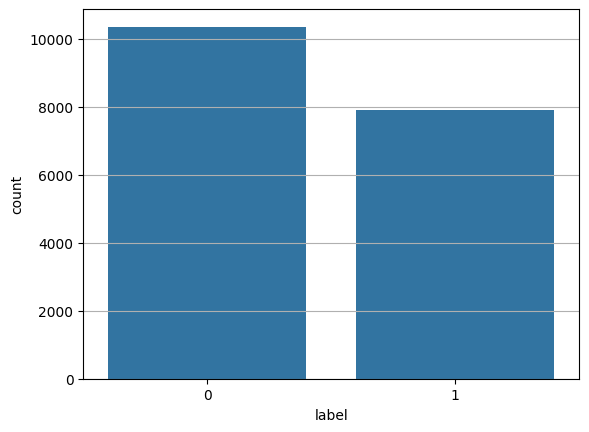

In [17]:
df.describe()
df.info()
df.shape
#rows and columns
df.isnull().sum()
df=df.dropna()
df.isnull().sum()
df['label'].hist()
_ = sns.countplot(x="label", data=df)

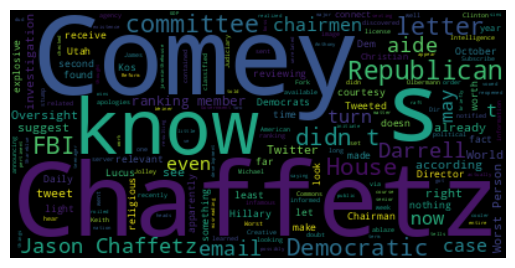

In [18]:
# WordCloud
text = df.text[0]
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
# Combine title and text (if 'text' exists)
df['content'] = df['title'].fillna('') + ' ' + df.get('text', '').fillna('')

**Data Preprocessing/Feature Engineering**

In [20]:
# Basic text preprocessing
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

In [21]:
df['clean_content'] = df['content'].apply(clean_text)

In [22]:
# Encode labels
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])  # 1: Real, 0: Fake

In [23]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], df['label_enc'], test_size=0.2, random_state=42)


In [24]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

**2. Reinforcement Learning Setup (Q-Learning)**

In [28]:
class FakeNewsEnv:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.index = 0
        self.n_samples = len(data)

    def reset(self):
        self.index = 0
        return self.data[self.index]

    def step(self, action):
        # Use .iloc to access by position instead of label
        true_label = self.labels.iloc[self.index]
        reward = 1 if action == true_label else -1

        self.index += 1
        done = self.index >= self.n_samples
        # Use .iloc to access by position instead of label
        next_state = self.data[self.index] if not done else None

        return next_state, reward, done

**3. Q-Learning Agent**

In [29]:
class QAgent:
    def __init__(self, state_size, action_size):
        self.q_table = np.random.uniform(low=0, high=1, size=(state_size, action_size))
        self.action_size = action_size
        self.state_size = state_size

    def choose_action(self, state_idx, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size)
        return np.argmax(self.q_table[state_idx])

    def learn(self, state_idx, action, reward, next_state_idx, alpha, gamma):
        old_value = self.q_table[state_idx, action]
        next_max = np.max(self.q_table[next_state_idx]) if next_state_idx is not None else 0
        new_value = old_value + alpha * (reward + gamma * next_max - old_value)
        self.q_table[state_idx, action] = new_value


**4. Train the Q-Learning Agent**

In [30]:
# Simplify states using hash (for demo purpose, reduce dimensionality)
def state_index(vec):
    return int(np.sum(vec) * 1000) % 5000

env = FakeNewsEnv(X_train_tfidf, y_train)
agent = QAgent(state_size=5000, action_size=2)

alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.2
episodes = 10

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    while True:
        state_idx = state_index(state)
        action = agent.choose_action(state_idx, epsilon)
        next_state, reward, done = env.step(action)
        next_state_idx = state_index(next_state) if not done else None
        agent.learn(state_idx, action, reward, next_state_idx, alpha, gamma)
        total_reward += reward
        if done:
            break
        state = next_state
    print(f"Episode {ep+1}: Total Reward = {total_reward}")


Episode 1: Total Reward = 126
Episode 2: Total Reward = 1800
Episode 3: Total Reward = 3036
Episode 4: Total Reward = 3754
Episode 5: Total Reward = 4194
Episode 6: Total Reward = 4410
Episode 7: Total Reward = 4552
Episode 8: Total Reward = 4738
Episode 9: Total Reward = 4660
Episode 10: Total Reward = 4768


** 5. Evaluate the Agent **

In [31]:
# Evaluate on test data
correct = 0
for i in range(len(X_test_tfidf)):
    state_idx = state_index(X_test_tfidf[i])
    action = np.argmax(agent.q_table[state_idx])
    if action == y_test.iloc[i]:
        correct += 1

accuracy = correct / len(y_test)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.5094339622641509


** 6. # Define prediction function **

In [32]:
# Define prediction function
def predict_fake_news(text):
    cleaned = clean_text(text)
    tfidf_vector = vectorizer.transform([cleaned]).toarray()[0]
    state_idx = state_index(tfidf_vector)
    action = np.argmax(agent.q_table[state_idx])
    label = le.inverse_transform([action])[0]
    return label


**7. Test**

In [33]:
sample_news = "Breaking: NASA discovers water on Mars"
prediction = predict_fake_news(sample_news)
print("Prediction:", prediction)


Prediction: 0


In [34]:
# multiple input
test_news_list = [
    "Government announces new healthcare policy",
    "Click here to win a free iPhone",
    "New study reveals benefits of meditation",
    "Aliens landed in my backyard last night"
]

for i, news in enumerate(test_news_list, 1):
    print(f"{i}. {news}")
    print("   ➤ Prediction:", predict_fake_news(news))


1. Government announces new healthcare policy
   ➤ Prediction: 0
2. Click here to win a free iPhone
   ➤ Prediction: 1
3. New study reveals benefits of meditation
   ➤ Prediction: 0
4. Aliens landed in my backyard last night
   ➤ Prediction: 0


**Save Mode for later use**

In [ ]:
import joblib
import numpy as np

joblib.dump(vectorizer, '/content/drive/My Drive/FakeNews/RLModel/vectorizer.joblib')
joblib.dump(le, '/content/drive/My Drive/FakeNews/RLModel/label_encoder.joblib')
np.save('/content/drive/My Drive/FakeNews/RLModel/q_table.npy', agent.q_table)

print("done")


done


In [40]:
# Test Reload Q-table
agent.q_table = np.load("/content/drive/My Drive/FakeNews/RLModel/q_table.npy")
print("loaded agina")

loaded agina


** lear add**